# Discretization (Binning)

Discretization is the process of transforming continuous variables into discrete variables by creating a set of continuous intervals that span the range of the variable's values. Discretization is also called binning, where bin is an alternative name for interval.

**Why use Discretization:**

- To handle outliers
- To improve the value spread

**Types of Discretization:**

- Unsupervised Binning
    - Equal Width Binning
    - Equal Frequency Binning (Quantile Binning)
    - K-means Binning
- Supervised Binning
    - DecisionTree Binning
- Custom Binning

## Equal Width/Uniform Binning

$$\text{bin width} = \frac{max - min}{\text{number of bins}}$$

**Advantages:**

- Can handle the outliers in better way
- The spread of the data will not changed

## Equal Frequency/Quantile Binning

![Quantile Binning](./images/image-2.png)

## KMeans Binning
KMeans clustering algorithm is used to create bins.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv("../Datasets/titanic/train.csv", usecols = ["Age", "Fare", "Survived"])
df.dropna(inplace = True)
df.shape

(714, 3)

In [3]:
df.sample(5)

,Survived,Age,Fare
424,0,18.0,20.2125
216,1,27.0,7.9250
392,0,28.0,7.9250
224,1,38.0,90.0000
695,0,52.0,13.5000


In [4]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.head()

,Age,Fare
328,31.0,20.5250
73,26.0,14.4542
253,30.0,16.1000
719,33.0,7.7750
666,25.0,13.0000


In [6]:
clf    = DecisionTreeClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.6293706293706294

In [7]:
np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv = 10, scoring = "accuracy"))

0.634546165884194

In [25]:
kbin_age  = KBinsDiscretizer(n_bins = 15, encode = "ordinal", strategy = "quantile")
kbin_fare = KBinsDiscretizer(n_bins = 15, encode = "ordinal", strategy = "quantile")

In [26]:
trf = ColumnTransformer([
    ("first", kbin_age, [0]),
    ("second", kbin_fare, [1])
])

In [27]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf  = trf.transform(X_test)

In [28]:
print(trf.named_transformers_["first"].n_bins_)
print(trf.named_transformers_["first"].bin_edges_)

[15]
[array([ 0.42,  6.  , 16.  , 19.  , 21.  , 23.  , 25.  , 28.  , 30.  ,
        32.  , 35.  , 38.  , 42.  , 47.  , 54.  , 80.  ])             ]


In [29]:
print(trf.named_transformers_["second"].n_bins_)
print(trf.named_transformers_["second"].bin_edges_)

[15]
[array([  0.    ,   7.25  ,   7.775 ,   7.8958,   8.1583,  10.5   ,
         13.    ,  14.4542,  18.75  ,  26.    ,  26.55  ,  31.275 ,
         51.4792,  76.2917, 108.9   , 512.3292])                   ]


In [30]:
output = pd.DataFrame({
    "age": X_train["Age"],
    "age_trf": X_train_trf[:, 0],
    "fare": X_train["Fare"],
    "fare_trf": X_train_trf[:, 1]
})

output.sample(5)

,age,age_trf,fare,fare_trf
722,34.0,9.0,13.0000,6.0
92,46.0,12.0,61.1750,12.0
319,40.0,11.0,134.5000,14.0
445,4.0,0.0,81.8583,13.0
463,48.0,13.0,13.0000,6.0


In [31]:
output["age_labels"]  = pd.cut(x = X_train["Age"], bins = trf.named_transformers_["first"].bin_edges_[0].tolist())
output["fare_labels"] = pd.cut(x = X_train["Fare"], bins = trf.named_transformers_["second"].bin_edges_[0].tolist())

output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
660,50.0,13.0,133.6500,14.0,"(47.0, 54.0]","(108.9, 512.329]"
726,30.0,8.0,21.0000,8.0,"(28.0, 30.0]","(18.75, 26.0]"
361,29.0,7.0,27.7208,10.0,"(28.0, 30.0]","(26.55, 31.275]"
554,22.0,4.0,7.7750,2.0,"(21.0, 23.0]","(7.25, 7.775]"
807,18.0,2.0,7.7750,2.0,"(16.0, 19.0]","(7.25, 7.775]"


In [32]:
clf     = DecisionTreeClassifier()

clf.fit(X_train_trf, y_train)
y_pred2 = clf.predict(X_test_trf)

accuracy_score(y_test, y_pred2)

0.6363636363636364

In [33]:
X_trf = trf.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv = 10, scoring = "accuracy"))

0.6359154929577465

In [46]:
def discretize(bins, strategy):
    kbin_age = KBinsDiscretizer(n_bins = bins, encode = "ordinal", strategy = strategy)
    kbin_fare = KBinsDiscretizer(n_bins = bins, encode = "ordinal", strategy = strategy)
    
    trf = ColumnTransformer([
        ("first", kbin_age, [0]),
        ("second", kbin_fare, [1])
    ])
    
    X_trf = trf.fit_transform(X)
    print(f'accuracy: {np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv = 10, scoring = "accuracy"))}')
    
    plt.figure(figsize = (16, 9))
    plt.subplot(221)
    plt.hist(X["Age"])
    plt.title(f"Before {strategy.capitalize()}, Age")
    
    plt.subplot(222)
    plt.hist(X_trf[:, 0], color = "red")
    plt.title(f"After {strategy.capitalize()}, Age")
    
    plt.subplot(223)
    plt.hist(X["Fare"])
    plt.title(f"After {strategy.capitalize()}, Fare")
    
    plt.subplot(224)
    plt.hist(X_trf[:, 1], color = "red")
    plt.title(f"After {strategy.capitalize()}, Fare")
    
    plt.show()

accuracy: 0.6261345852895148


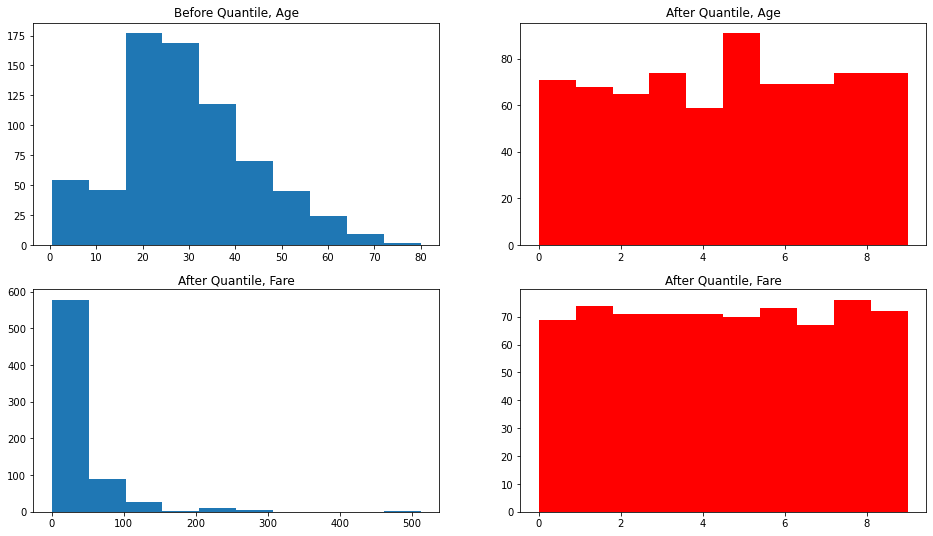

In [43]:
discretize(bins = 10, strategy = "quantile")

accuracy: 0.6316705790297339


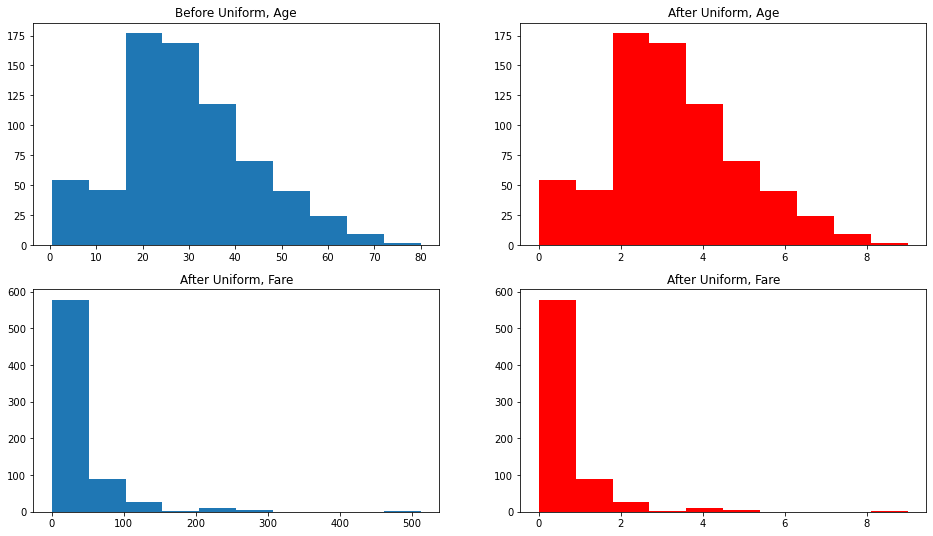

In [44]:
discretize(bins = 10, strategy = "uniform")

accuracy: 0.6303012519561815


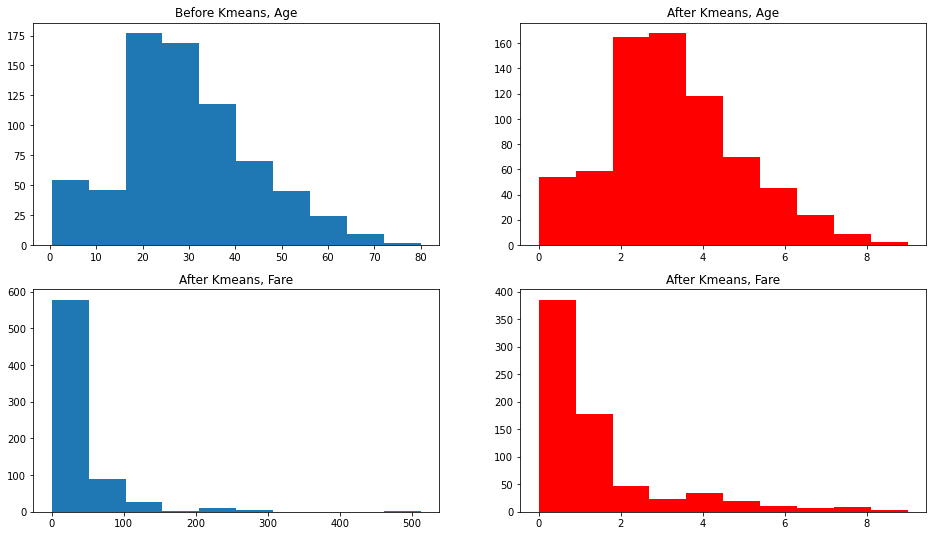

In [45]:
discretize(bins = 10, strategy = "kmeans")

## Custom/Domain Based Binning

You can create custom binning based on your domain knowledge, like [0-18] aged peoples are kids, [18-60] aged peoples are adults, [60-80] aged peoples are old and like that. But you have to build the login on your own.

# Binarization
In discretization, you are converting continuous values to descrete values. But in binarization, you are converting the continuous values to binary (0 or 1). E.g., If your income is less than 6L, then you are not under taxable zone otherwise you are under taxable zone. This technique is used to convert colored image to black-and-white image.

In [49]:
df = pd.read_csv("../Datasets/titanic/train.csv")[["Age", "Fare", "SibSp", "Parch", "Survived"]]
df.dropna(inplace = True)
df.head()

,Age,Fare,SibSp,Parch,Survived
0,22.0,7.2500,1,0,0
1,38.0,71.2833,1,0,1
2,26.0,7.9250,0,0,1
3,35.0,53.1000,1,0,1
4,35.0,8.0500,0,0,0


In [51]:
df["family"] = df["SibSp"] + df["Parch"]
df.head()

,Age,Fare,SibSp,Parch,Survived,family
0,22.0,7.2500,1,0,0,1
1,38.0,71.2833,1,0,1,1
2,26.0,7.9250,0,0,1,0
3,35.0,53.1000,1,0,1,1
4,35.0,8.0500,0,0,0,0


In [52]:
df.drop(columns = ["SibSp", "Parch"], inplace = True)
df.head()

,Age,Fare,Survived,family
0,22.0,7.2500,0,1
1,38.0,71.2833,1,1
2,26.0,7.9250,1,0
3,35.0,53.1000,1,1
4,35.0,8.0500,0,0


In [53]:
X = df.drop(columns = ["Survived"])
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.head()

,Age,Fare,family
328,31.0,20.5250,2
73,26.0,14.4542,1
253,30.0,16.1000,1
719,33.0,7.7750,0
666,25.0,13.0000,0


In [54]:
# without binarization
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.6433566433566433

In [55]:
np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv = 10, scoring = "accuracy"))

0.6428794992175274

In [56]:
# applying binarization

from sklearn.preprocessing import Binarizer

In [57]:
trf = ColumnTransformer([
    ("bin", Binarizer(copy = False), ["family"])
], remainder = "passthrough")

X_train_trf = trf.fit_transform(X_train)
X_test_trf  = trf.transform(X_test)

In [58]:
pd.DataFrame(X_train_trf, columns = ["Family", "Age", "Fare"])

,Family,Age,Fare
0,1.0,31.0,20.5250
1,1.0,26.0,14.4542
2,1.0,30.0,16.1000
3,0.0,33.0,7.7750
4,0.0,25.0,13.0000
...,...,...,...
566,1.0,46.0,61.1750
567,0.0,25.0,13.0000
568,0.0,41.0,134.5000
569,1.0,33.0,20.5250


In [59]:
clf2 = DecisionTreeClassifier()
clf2.fit(X_train_trf, y_train)

y_pred2 = clf.predict(X_test)

accuracy_score(y_test, y_pred2)

0.6433566433566433

In [60]:
X_trf2 = trf.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(), X_trf2, y, cv = 10, scoring = "accuracy"))

0.6262323943661972